<a href="https://colab.research.google.com/github/A3labmarche/DL4SP_notebooks/blob/main/audio_equalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
### importo tensorflow
import tensorflow as tf

### importo scipy e numpy
from scipy.io import loadmat  # loadmat è una funzione che permette di caricare i file .mat
import numpy as np
from tensorflow.python.keras import backend as K

### importo le API di tensorflow
from tensorflow.keras.models import Sequential,Model   
from tensorflow.keras.layers import Input,Dense, Activation, Flatten, Layer,Conv2D,Lambda,Concatenate,Conv1D,Dropout, Multiply
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [ ]:
# download data
!wget -nc -O IR.zip "https://drive.google.com/uc?export=download&id=1MhFt5RErTHXuY7ir2ZzZ3MdJYW33CfAC"
!unzip -q IR.zip

File ‘IR.zip’ already there; not retrieving.
replace IR.mat? [y]es, [n]o, [A]ll, [N]one, [r]ename: y


In [ ]:
fs=48000   # frequenza di campionamento
NFFT=int(np.power(2,np.ceil(np.log2(fs))))  #calcolo della NFFT
channel=1  # numero di microfoni
sources=1  # numero di altoparlanti
augment_NFFT=2  # aumento della risoluzione della NFFT per la convoluzione in frequenza

### caricamento risposta impulsiva, fs=48000y
i=loadmat('IR.mat')
IR=i['s_1_5']  # prendo la risposta impulsiva tra il quinto altoparlante e il primo micorofono, ha dimensione [numero di microfoni,numerodi sorgenti, lunghezza IR]=[1,1,48000]

IR=np.expand_dims(np.expand_dims(IR,0),0) # inserisco la dimensione del batch (1)
print(np.shape(IR)) # [1,1,1,48000]

(1, 1, 1, 48000)


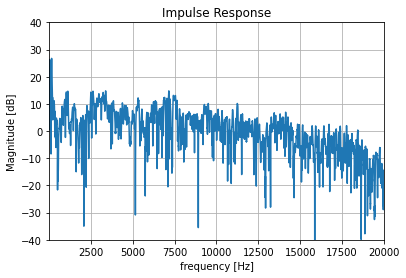

In [ ]:
#  grafico la risposta in ampiezza della IR
abs_IR=np.abs(np.fft.fft(IR[0,0,0],NFFT))
freq=np.arange(0,NFFT/2)*fs/NFFT
plt.plot(freq,20*np.log10(abs_IR[0:int(NFFT/2)]))
plt.axis([20 ,20000, -40, 40])
plt.xlabel('frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.title('Impulse Response')
plt.grid()
plt.show()

In [ ]:
epsilon=1e-7 # costante molto piccola

neurons_dense=[4096,2048,1024,512]  # numero di neuroni per ogni Dense Layer
order=8192  # ordine del filtro FIR
lenFir=order+1 # numero di tappi del filtro FIR
iterations=100  #  numero di iterazioni
filters=np.shape(IR)[1]  #  numero di filtri, uguale al numero di sorgenti (1 FIR per ogni altoparlante)
output_parameters=lenFir*filters  # numero di parametri in uscita, sono i coefficienti dei filtri FIR per tutti i filtri FIR
eps_complex=K.constant(tf.cast(tf.complex(1e-30,1e-30),dtype=tf.complex64),dtype=tf.complex64)


IRpadded=tf.pad(IR,K.constant([[0,0],[0,0],[0,0],[0,augment_NFFT*NFFT-fs]],dtype=tf.int32), "CONSTANT")  #  creo il pad per la FFT


Qi=int(50*NFFT/fs)  #  frequenza minima della banda che voglio equalizzare
Qf=int(14000*NFFT/fs)  #  frequenza massima della banda che voglio equalizzare


lr=0.0001  #  learning rate
filters_array=K.variable(value=np.zeros((1,filters,lenFir)),dtype=tf.float32)  #  array che mi permette di salvare i filtri ottimizzati dalla rete
abs_out=K.variable(value=np.zeros((1,channel,int(NFFT/2))),dtype=tf.float32)  #  array che mi permette di salvare la risposta in frequenza ottenuta dalla simulazione

##  definizione della funzione di attivazione custom
def sin_activation(x,w_0=1):
    return tf.math.sin(epsilon+x)+epsilon

tf.keras.activations.sin_activation = sin_activation

# Lambda Layer dove sistemo i filtri FIR da un array a un tensore di dimensione [BATCH, filtri, coefficienti]
def filter_layer(inputLayer):
    fir=epsilon+K.reshape(inputLayer[:,0:filters*lenFir],(K.shape(inputLayer)[0],filters,lenFir))
    filters_array.assign(fir)  # salvo i filtri ottenuti
    return fir

# Lambda Layer in cui effettuo la convoluzione in frequenza
def impulse_response(inputLayer):
    fir_new=epsilon+K.reshape(K.tile(inputLayer,(channel,1,1)),(K.shape(inputLayer)[0],channel,sources,lenFir))  # copio i filtri in base al numero di microfoni
    fir_new=tf.cast(tf.pad(fir_new,K.constant([[0,0],[0,0],[0,0],[0,augment_NFFT*NFFT-lenFir]],dtype=tf.int32), "CONSTANT"),dtype=tf.complex64)  # aggiungo il padding ai filtri per la FFT
    FIR=tf.signal.fft(fir_new)  #  effettuo la FFT

    #  aggiungo la dimensione del batch alle IR e converto il tensore nel tipo complesso
    IR_pad=eps_complex+tf.cast(K.reshape(K.tile(IRpadded,(K.shape(inputLayer)[0],1,1,1)),(K.shape(inputLayer)[0],channel,sources,augment_NFFT*NFFT)),dtype=tf.complex64)
    IR_FFT=tf.signal.fft(IR_pad)

    # convoluzione in frequenza
    TEM=IR_FFT*(FIR+eps_complex)+eps_complex
    
    #  IFFT
    ntempp=epsilon+tf.cast(tf.math.real(tf.signal.ifft(TEM)),dtype=tf.float32)
    outputLayer=epsilon+K.reshape(ntempp[:,:,:,0:fs],(K.shape(inputLayer)[0],channel,sources,fs))
    return outputLayer

## Lambda layer che somma le IR filtrate sugli altoparlanti
def output_impulse_responses_layer(InputLayer):
    output=epsilon+K.sum(InputLayer+epsilon,axis=2)+epsilon  #[BATCH, microfoni, fs]
    return output


## Lambda layer dove ottengo la risposta in ampiezza bin per bin
def fft_layer(inputLayer):
    o=tf.cast(tf.pad(inputLayer,[[0, 0],[ 0, 0],[ 0, int(NFFT-fs)]]),dtype=tf.complex64)
    t3=tf.cast(o,dtype=tf.complex64)
    T=tf.signal.fft(t3)
    T_abs=tf.cast(tf.abs(T[:,:,0:int(NFFT/2)]),dtype=tf.float32)
    abs_out.assign(T_abs)
    return T_abs


## Loss distanza euclidea tra risposta in ampiezza desiderata e ottenuta dalla simulazione
## Loss realizzata come Lambda Layer
def euclidean_distance_magnitude(inputLayer):
    """
    calcolo dell'errore tra la risposta in frequenza desiderata e quella ottenuta, ampiezza in scala lineare
    params:
    inputLayer: frequency response
    """
    one_desired=K.ones_like(inputLayer)  ## risposta desiderata 0 dB in scala lineare
    
    euclidean_distance_magnitude=epsilon+K.sum(epsilon+K.sqrt(epsilon+K.sum(epsilon+K.square(one_desired[:,:,Qi:Qf]-inputLayer[:,:,Qi:Qf]),axis=-1)),axis=1,keepdims=True)
    return euclidean_distance_magnitude

## somma delle loss
def sum_loss(y_true,y_pred):
    return K.sum(y_pred)

## definizione della rete
InputBias=Input(shape=[1])
dense=Dense(neurons_dense[0],activation=sin_activation,kernel_initializer=tf.keras.initializers.RandomUniform(minval=-1e0, maxval=1e0, seed=None),bias_initializer=tf.keras.initializers.RandomUniform(minval=-1e-2, maxval=1e-2, seed=None),use_bias=True)(InputBias)
for i in range(1,len(neurons_dense)):
    dense=Dense(neurons_dense[i],activation=sin_activation,kernel_initializer=tf.keras.initializers.RandomUniform(minval=-1e-2, maxval=1e-2, seed=None))(dense)
fir_layer=Dense(output_parameters,activation=sin_activation,kernel_initializer=tf.keras.initializers.RandomUniform(minval=-1e-2, maxval=1e-2, seed=None))(dense)
filters_layer=Lambda(filter_layer)(fir_layer)   #Lambda layer: permette di creare dei layer customizzati, come nel nostro caso
imp_layer=Lambda(impulse_response)(filters_layer)
out_layer=Lambda(output_impulse_responses_layer)(imp_layer)
fft_layer=Lambda(fft_layer)(out_layer)

## definizione della loss
loss=Lambda(euclidean_distance_magnitude)(fft_layer)
total_loss=Dense(1,use_bias=False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(value=1.0),trainable=False)(loss)

The following Variables were used a Lambda layer's call (lambda), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=(1, 1, 8193) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (lambda_3), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=(1, 1, 32768) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


epoch: 1 loss: 137.72540283203125
epoch: 2 loss: 132.9473876953125
epoch: 3 loss: 126.645263671875
epoch: 4 loss: 117.40156555175781
epoch: 5 loss: 106.23997497558594
epoch: 6 loss: 96.94367980957031
epoch: 7 loss: 97.29386901855469
epoch: 8 loss: 90.63888549804688
epoch: 9 loss: 82.20989990234375
epoch: 10 loss: 79.90108489990234
epoch: 11 loss: 77.48531341552734
epoch: 12 loss: 75.04751586914062
epoch: 13 loss: 70.09984588623047
epoch: 14 loss: 67.46123504638672
epoch: 15 loss: 65.85335540771484
epoch: 16 loss: 67.01282501220703
epoch: 17 loss: 63.02204895019531
epoch: 18 loss: 60.60023880004883
epoch: 19 loss: 58.170387268066406
epoch: 20 loss: 58.398311614990234
epoch: 21 loss: 55.977745056152344
epoch: 22 loss: 54.42294692993164
epoch: 23 loss: 52.264305114746094
epoch: 24 loss: 51.48495101928711
epoch: 25 loss: 51.6927604675293
epoch: 26 loss: 48.10633850097656
epoch: 27 loss: 47.32991409301758
epoch: 28 loss: 46.53317642211914
epoch: 29 loss: 46.12207794189453
epoch: 30 loss: 44

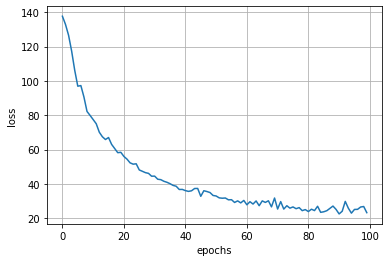

In [ ]:
model=Model(inputs=[InputBias],outputs=[total_loss])
optimizer = Adam(learning_rate=lr, decay=1e-4)
model.compile(loss=[sum_loss], optimizer=optimizer)

## inizio della ottimizzazione
_loss=1e10
losses=[]
for i in range(iterations):
    # ottimizzazione di una iterazione
    loss=model.train_on_batch([[np.zeros((1))]], [[np.zeros((1))]])    
    if loss<_loss:#losses[-1]:
      best_fir=K.eval(filters_array) # salva in una variabile il filtro ottenuto dal modello
      best_abs=K.eval(abs_out) # salva in una variabile la risposta in frequenza ottenuta
    losses.append(loss)
    print('epoch: '+str(i+1)+' loss: '+str(loss))

plt.plot(losses)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.show()

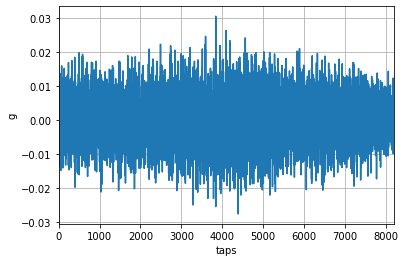

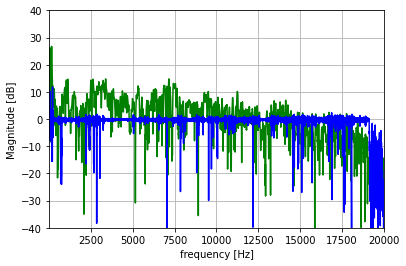

In [ ]:
# print(best_fir)
fir=best_fir[0]
# print(fir)
plt.plot(fir[0])
plt.xlabel('taps')
plt.ylabel('g')
plt.xlim(0,lenFir)
plt.grid()
plt.show()

plt.plot(freq,20*np.log10(abs_IR[0:int(NFFT/2)]),'g',20*np.log10(best_abs[0,0]),'b')
plt.axis([20,20000,-40,40])
plt.xlabel('frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid()
plt.show()